# AC Optics

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from analysis import *
import glob
import re
import hvplot.xarray
font = {'family':'serif',
        'weight': 'normal',
        'size': 32}
plt.rc('font',**font)
import matplotlib as mpl
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#000000','#e3130f','#0962f6',
                                                    '#20c168','#fc76f3','#2efef4'])
plt.rc('text',usetex=True)

## Constants

In [2]:
mu0 = np.pi*4*1e-7
Ms = 0.93/mu0 # T
hbar = 1.055e-34
e = 1.6e-19
V = 1. #Vrms
R = 336.123 #ohms
w = 20e-4 #cm
t = 4e-7 #cm
A = w*t
I = V/R
J = I/A
tco = 1.15e-9
rho_co = 9.59e-8 #ohm m
rho_pt = 40e-8 #33.33e-8 #ohm m
R4pt = 1/(1/(rho_pt*80e-6/20e-6/4e-9) + 1/(rho_co*80e-6/20e-6/tco))
Isplit = rho_co*80e-6/20e-6/tco/(rho_pt*80e-6/20e-6/4e-9 + rho_co*80e-6/20e-6/tco)
t2xi = 2*e*Ms*tco/hbar/1e4

## OOP hyst

In [3]:
OOP = pd.read_csv('./C5R8_OOP_SagnacHeterodyne_V1.0000V_A90.0_2021-04-08_1.csv',comment='#')
# (m,b) = np.polyfit(OOP.sweep_field[:100],OOP.ThetaK[:100],1)
# OOP['ThetaK_corr'] = OOP['ThetaK'] - (m*OOP['sweep_field'])
OOP = OOP.set_index('sweep_field').drop(columns='elapsed_time').to_xarray()

No handles with labels found to put in legend.


0.00942251634134586


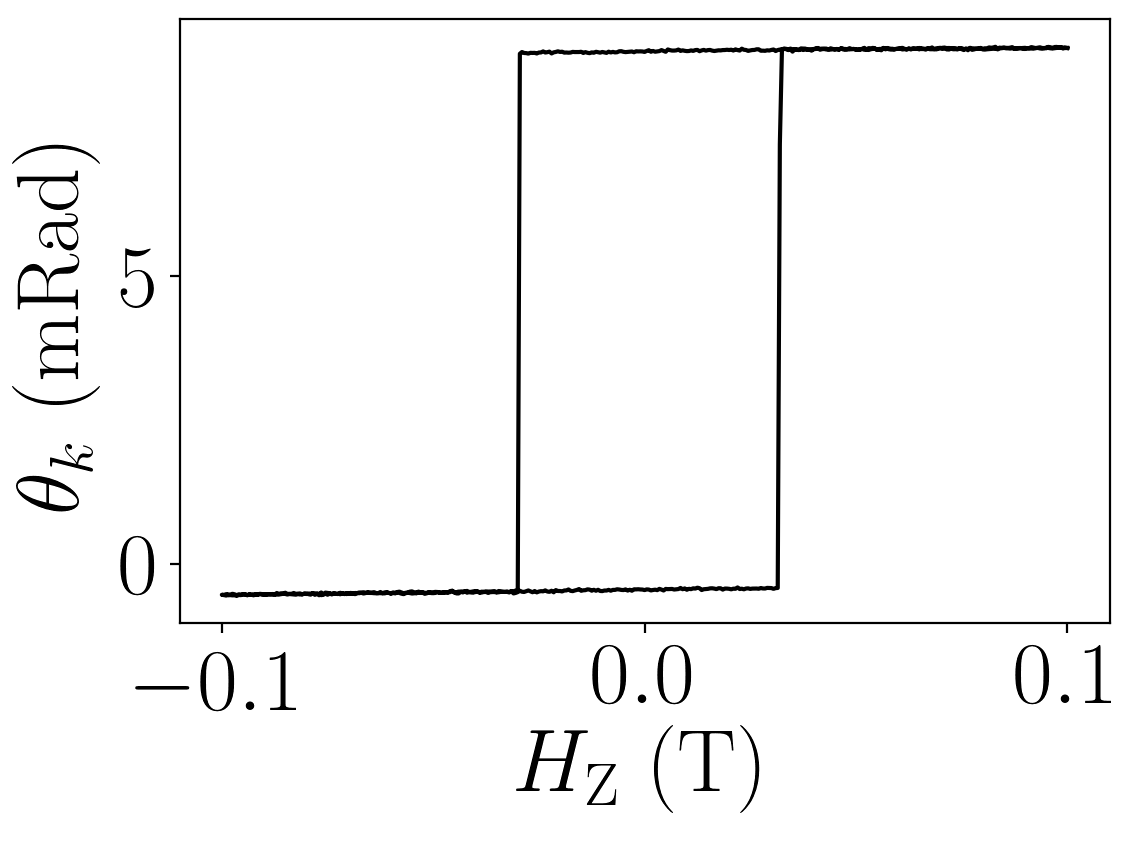

In [4]:
plt.figure(dpi=200)
plt.plot(OOP.sweep_field,-OOP.ThetaK*1e3)#,label='Raw')
# plt.plot(OOP.sweep_field,OOP.ThetaK_corr*1e3,label='Corrected')
plt.ylabel('$\\theta_k$ (mRad)')
plt.xlabel('$H_{\\rm{Z}}$ (T)')
plt.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=18)
plt.xticks([-0.1,0,0.1])
Mp = float(OOP.where(OOP.ThetaK*1e3 > -5.0).mean().ThetaK)
Mm = float(OOP.where(OOP.ThetaK*1e3 < -5.0).mean().ThetaK)
Mpi = (Mp - Mm)
print(Mpi)

0.3548465783757197


0.00597198633673463

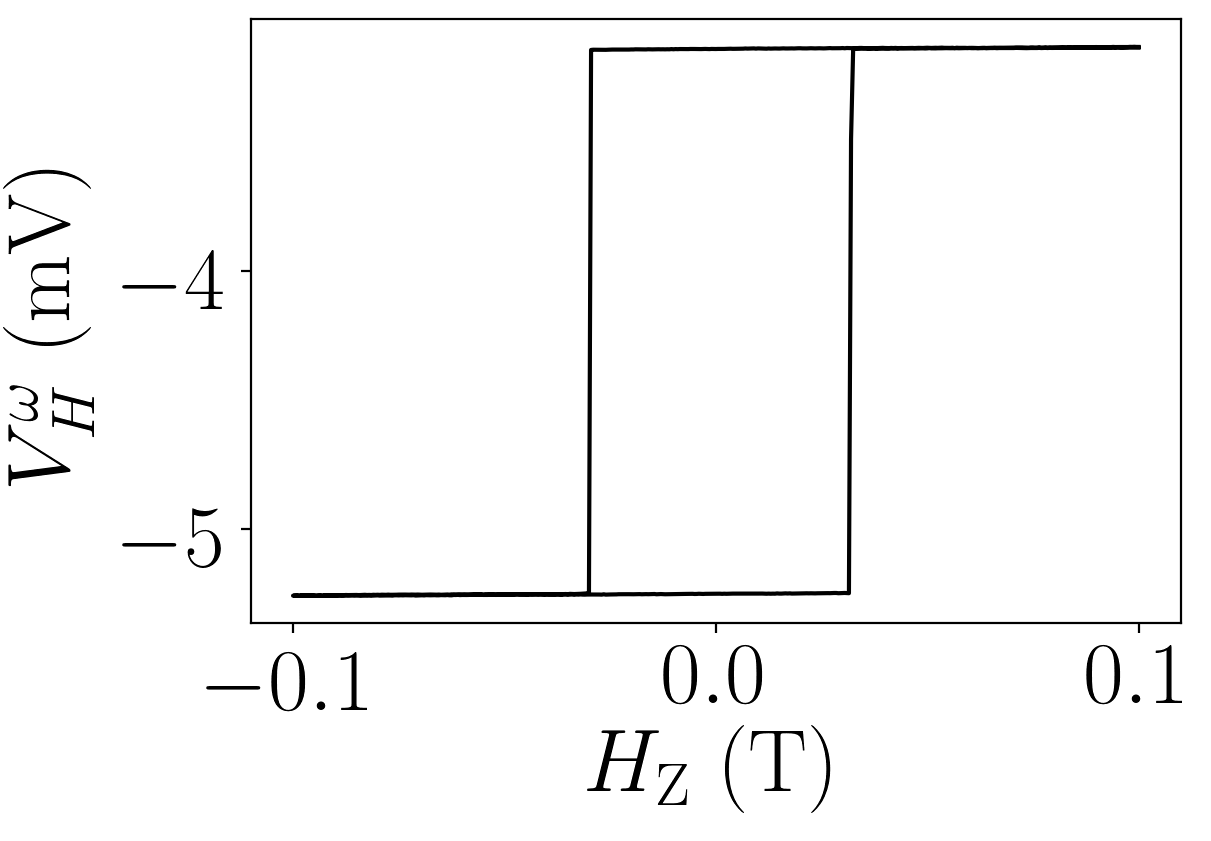

In [59]:
plt.figure(dpi=200)
plt.plot(OOP.sweep_field,OOP.TX1*1e3)
plt.ylabel('$V^{\\omega}_H$ (mV)')
plt.xlabel('$H_{\\rm{Z}}$ (T)')
plt.xticks([-0.1,0,0.1])
Mp = float(OOP.where(OOP.TX1*1e3 > -4.0).mean().TX1)
Mm = float(OOP.where(OOP.TX1*1e3 < -4.0).mean().TX1)
Vahe = (Mp - Mm)/2
Rahe = Vahe/I
print(Rahe) #ohms
float(OOP.where(OOP.TX1*1e3 > -4.0).std().TX1/I)

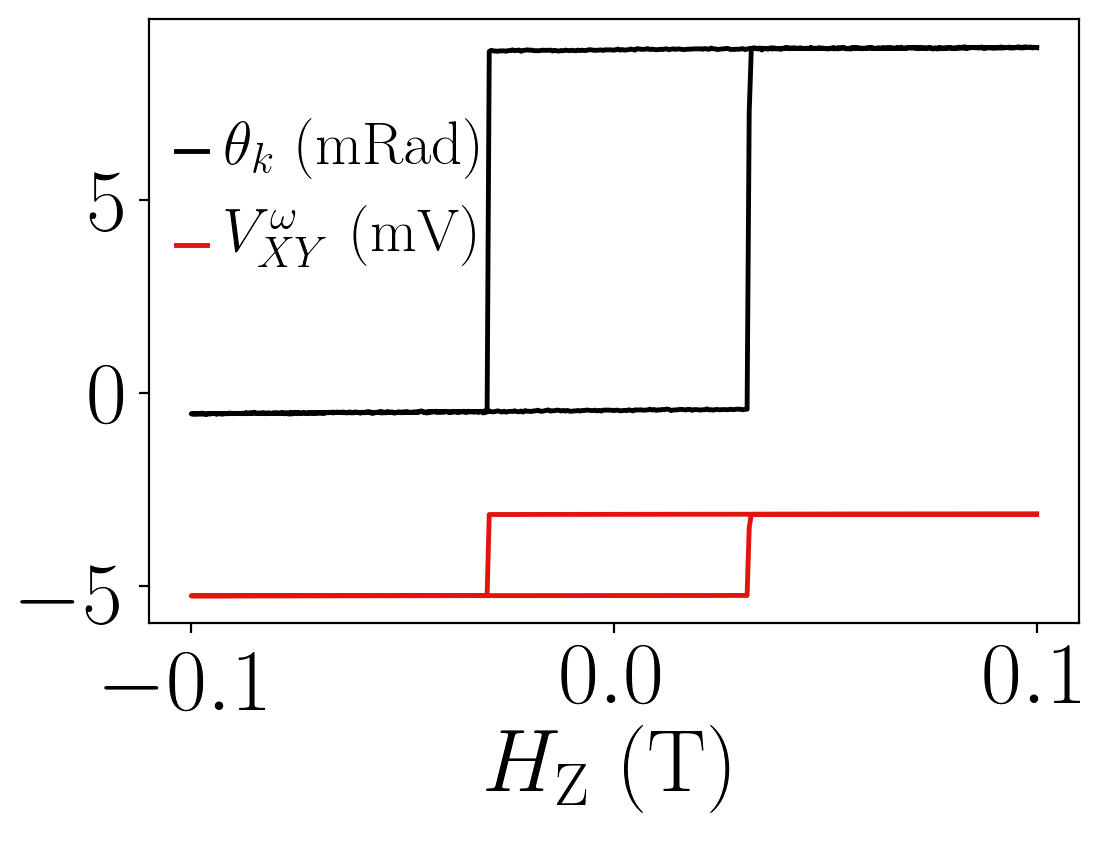

In [6]:
plt.figure(dpi=200)
plt.plot(OOP.sweep_field,-OOP.ThetaK*1e3,linewidth=1.75,label='$\\theta_k$ (mRad)')
plt.plot(OOP.sweep_field,OOP.TX1*1e3,linewidth=1.75,label='$V^{\\omega}_{XY}$ (mV)')
plt.xlabel('$H_{\\rm{Z}}$ (T)')
plt.xticks([-0.1,0,0.1])
plt.yticks([-5,0,5])
plt.legend(loc='center left',bbox_to_anchor=(-0.03,0.7),ncol=1,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=0.5,fontsize=22)

## PHE

In [19]:
def find_field(f):
    z = re.compile('.*F(?P<B>\-?\d+\.\d+)T.*')
    return float(re.match(z,f)['B'])
def load_phe(f):
    return pd.read_csv(f,comment='#').set_index('field_azimuth').drop(columns='elapsed_time').to_xarray()
phe = combine_new_dim({find_field(f): load_phe(f) for f in glob.glob('./*PHE*V1.0V*.csv')}, 'field_strength')

In [20]:
phe.hvplot('field_azimuth','TY2')

:DynamicMap   [field_strength]
   :Curve   [field_azimuth]   (TY2)

Text(0, 0.5, '$V^{\\omega}_H$ (mV)')

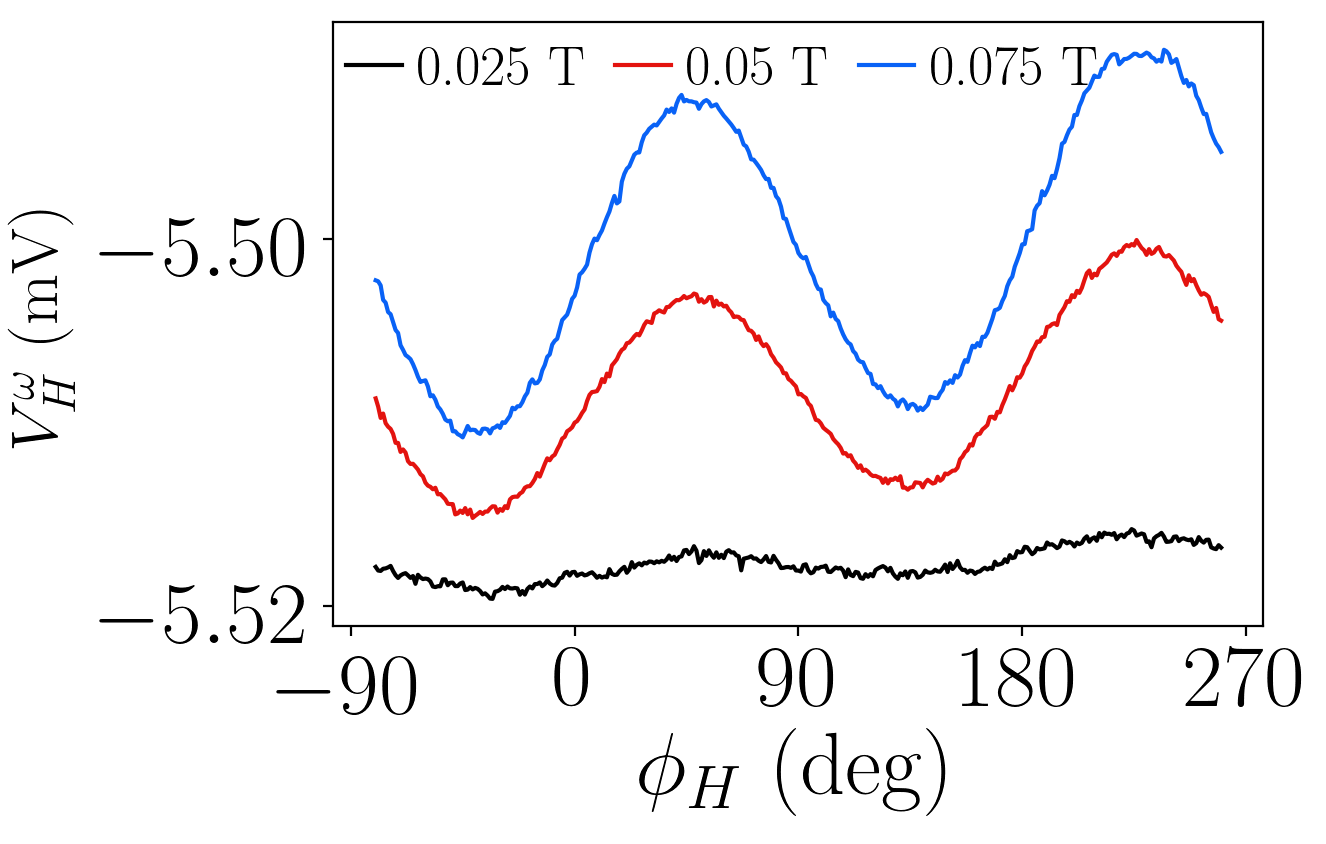

In [21]:
# plt.figure(dpi=200,figsize=(8,2))
plt.figure(dpi=200)
plt.plot(phe.field_azimuth+90,phe.sel(field_strength=0.025).TX1*1e3,label='0.025 T')
plt.plot(phe.field_azimuth+90,phe.sel(field_strength=0.06).TX1*1e3,label='0.05 T')
plt.plot(phe.field_azimuth+90,phe.sel(field_strength=0.075).TX1*1e3,label='0.075 T')
plt.legend(loc='upper left',bbox_to_anchor=(-0.04,1.05),ncol=3,frameon=False,
           columnspacing=0.5,handletextpad=0.3,handlelength=1,fontsize=20)
plt.xlabel('$\\phi_H$ (deg)')
plt.xticks([-90,0,90,180,270])
plt.ylabel('$V^{\\omega}_H$ (mV)',fontsize=24)

In [22]:
phe.hvplot('field_azimuth','TY2')

:DynamicMap   [field_strength]
   :Curve   [field_azimuth]   (TY2)

In [23]:
def sin2(x,x0,a,b):
    deg2rad = np.pi/180.
    return a/2*np.sin(2*deg2rad*(x-x0)) + b
def sin2_guess(*args,**kwargs):
    return [1,1,1]


    
phe_fit = fit_dataArray(phe.TX1,sin2,sin2_guess,['phi0','a','b'],'field_azimuth')

0.002849894354703261


0.20063067862220027

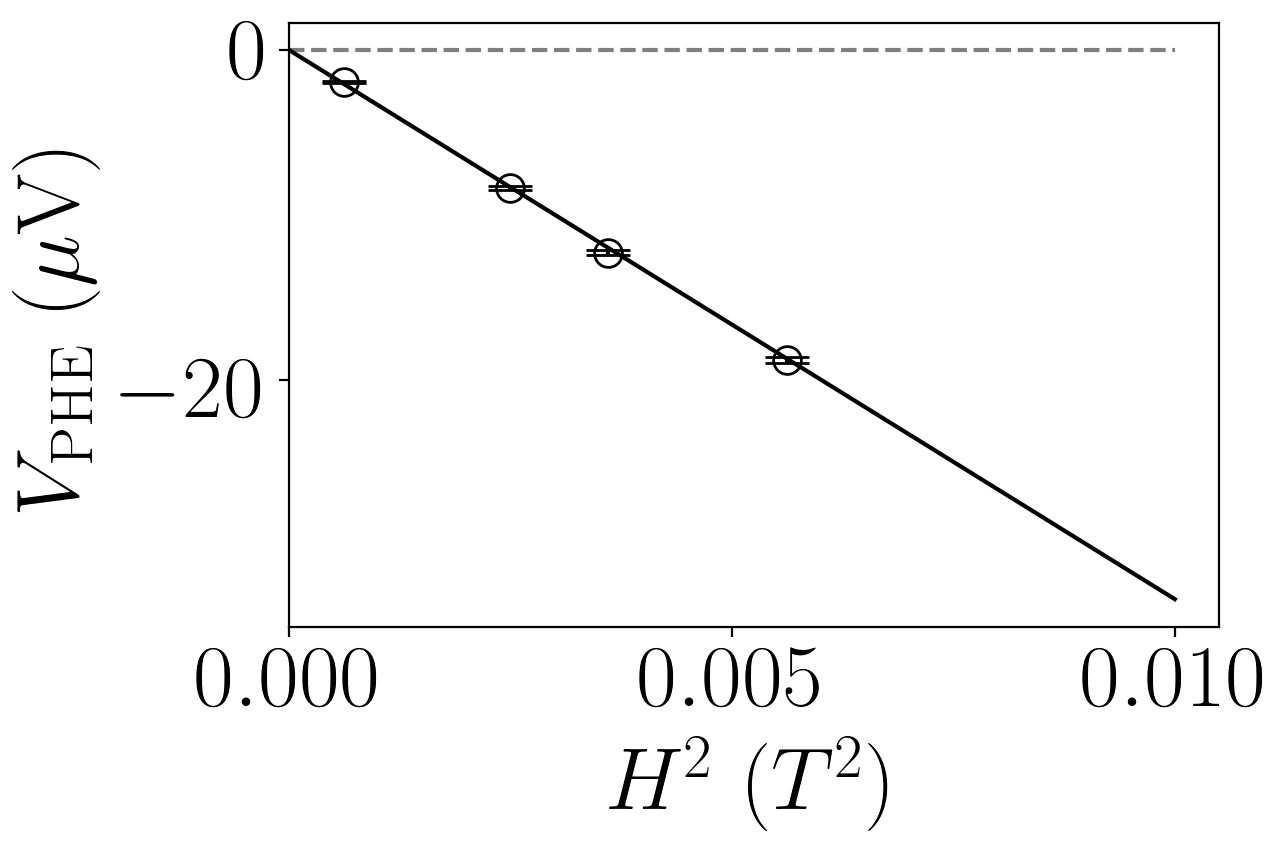

In [57]:
plt.figure(dpi=200)
plt.errorbar(phe_fit.field_strength**2,phe_fit.a*1e6,phe_fit.a_err*1e6,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.plot([0,0.01],[0,0],'k--',alpha=0.5)
plt.xlim(0,)
plt.xlabel('$H^2$ ($T^2$)')
plt.ylabel('$V_{\\rm{PHE}}$ ($\\mu$V)')
popt,pcov = np.polyfit(np.append([0],phe_fit.field_strength.values)**2,
                  np.append([0],phe_fit.a),1,
                  w=1/(np.append([1e-10],phe_fit.a_err)**2),cov=True)
plt.plot([0,0.01],np.polyval(popt,[0,0.01])*1e6)
Rphe = -popt[0]/I*xport_Meff**2#float(phe_fit.a/phe_fit.field_strength**2/I*xport_Meff**2)
print(np.sqrt(np.diag(pcov)[0])/I*xport_Meff**2)#float(phe_fit.a/phe_fit.field_strength**2/I*xport_Meff**2)

Rphe

### Quantifying the sample/field Tilt

In [25]:
def sin2cos(x,x0,x02,a,b,c):
    deg2rad = np.pi/180.
    return a/2*np.sin(2*deg2rad*(x-x0)) + b*np.sin(deg2rad*(x-x02)) + c
def sin2cos_guess(*args,**kwargs):
    return [1,1,1,1,1]
phe_fit_tilt = fit_dataArray(phe.TX1,sin2cos,sin2cos_guess,
                             ['phi0','phi02','a','b','c'],
                             'field_azimuth',bounds=((-180,-180,0,0,-np.inf),(180,180,np.inf,np.inf,np.inf)))

Text(0, 0.5, '$\\theta_k$ ($\\mu$rad)')

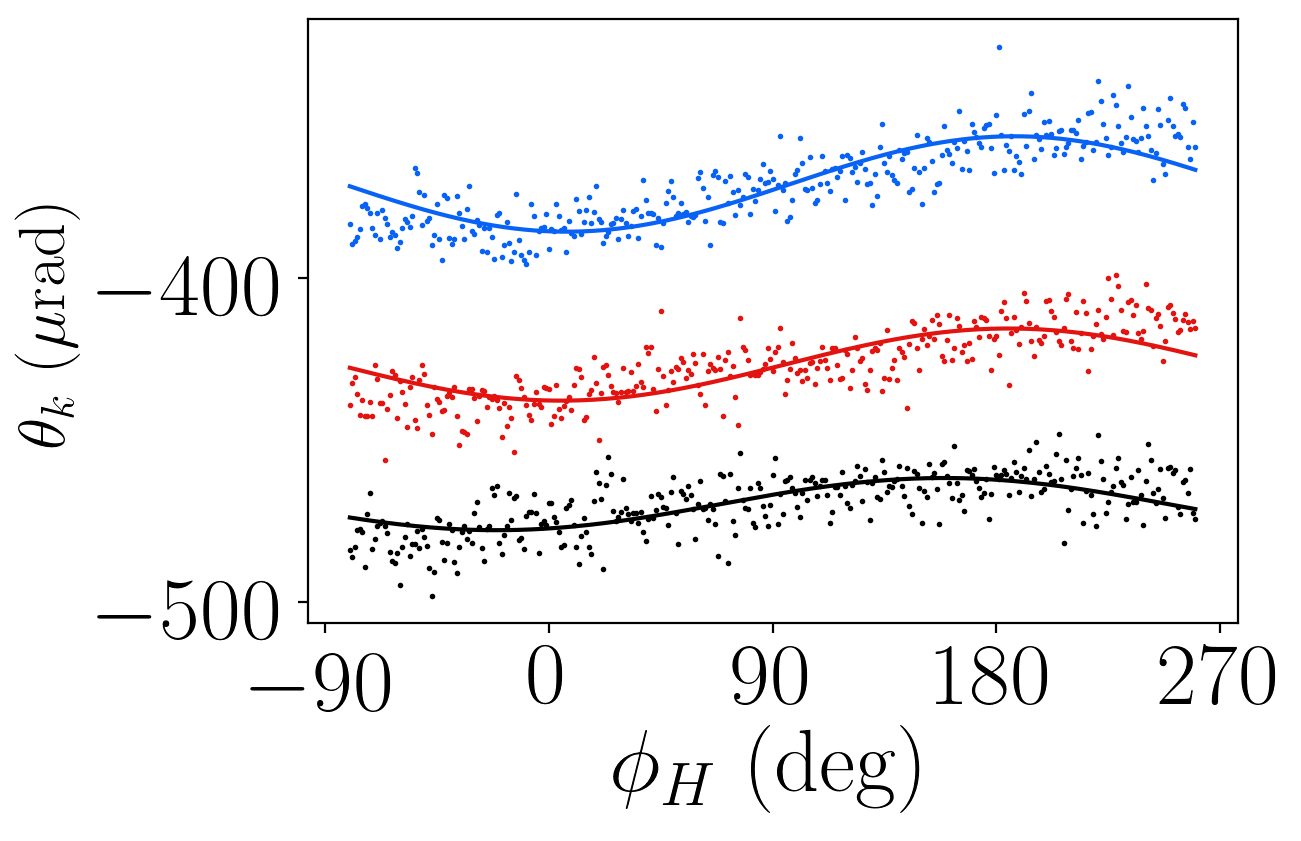

In [26]:
# plt.figure(dpi=200,figsize=(8,2))
plt.figure(dpi=200)
plt.errorbar(phe.field_azimuth+90,-phe.sel(field_strength=0.025).ThetaK*1e6-50,label='0.025 T',
             fmt='o',fillstyle='none',ms=1,color='C0')
plt.errorbar(phe.field_azimuth+90,-phe.sel(field_strength=0.05).ThetaK*1e6+75,label='0.05 T',
             fmt='o',fillstyle='none',ms=1,color='C1')
plt.errorbar(phe.field_azimuth+90,-phe.sel(field_strength=0.075).ThetaK*1e6+50,label='0.075 T',
             fmt='o',fillstyle='none',ms=1,color='C2')
# plt.legend(loc='lower left',bbox_to_anchor=(0,-0.1),ncol=3,frameon=False,
#            columnspacing=0.5,handletextpad=0.3,handlelength=1,fontsize=20)
# plt.legend(loc='upper left',bbox_to_anchor=(0,1.05),ncol=3,frameon=False,
#            columnspacing=0.5,handletextpad=0.3,handlelength=1,fontsize=20)
plt.xlabel('$\\phi_H$ (deg)')
plt.ylabel('$\\theta_k$ ($\\mu$rad)',fontsize=24)
# plt.ylim(-350,)
def cos(x,x0,a,b):
    return a*np.cos(np.pi/180*(x-x0)) + b
def cos_guess(*args,**kwargs):
    return [1,1,1]
qmoke_fit = fit_dataArray(phe.ThetaK,cos,cos_guess,['phi0','a','b'],'field_azimuth')
(m,b)= np.polyfit(qmoke_fit.field_strength**2,abs(qmoke_fit.a),1)
m*optics_Meff**2
# plt.figure(dpi=200)
# plt.plot(phe.field_azimuth+90,-phe.sel(field_strength=0.075).ThetaK*1e6,label='0.075 T')
plt.plot(phe.field_azimuth+90,-cos(phe.field_azimuth,
                               qmoke_fit.phi0.sel(field_strength=0.025),
                               qmoke_fit.a.sel(field_strength=0.025),
                               qmoke_fit.b.sel(field_strength=0.025))*1e6-50,color='C0')
plt.plot(phe.field_azimuth+90,-cos(phe.field_azimuth,
                               qmoke_fit.phi0.sel(field_strength=0.05),
                               qmoke_fit.a.sel(field_strength=0.05),
                               qmoke_fit.b.sel(field_strength=0.05))*1e6+75,color='C1')
plt.plot(phe.field_azimuth+90,-cos(phe.field_azimuth,
                               qmoke_fit.phi0.sel(field_strength=0.075),
                               qmoke_fit.a.sel(field_strength=0.075),
                               qmoke_fit.b.sel(field_strength=0.075))*1e6+50,color='C2')

plt.xlabel('$\\phi_H$ (deg)')
plt.xticks([-90,0,90,180,270])

plt.ylabel('$\\theta_k$ ($\\mu$rad)',fontsize=24)

Text(0, 0.5, '$V^{\\omega}_{XY}$ (mV)')

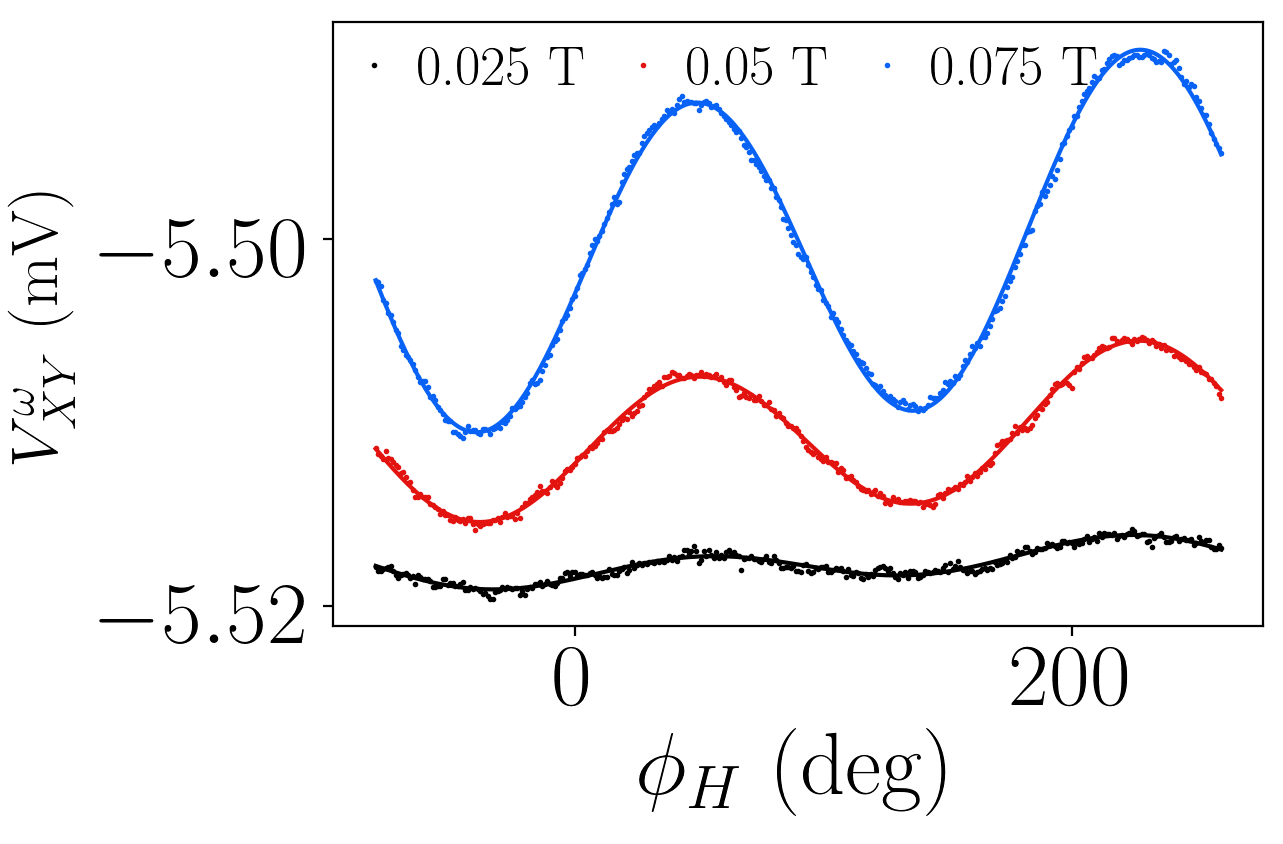

In [27]:
# plt.figure(dpi=200,figsize=(8,2))
plt.figure(dpi=200)
plt.errorbar(phe.field_azimuth+90,phe.sel(field_strength=0.025).TX1*1e3,label='0.025 T',
             fillstyle='none',fmt='o',ms=1)
plt.errorbar(phe.field_azimuth+90,phe.sel(field_strength=0.05).TX1*1e3,label='0.05 T',
             fillstyle='none',fmt='o',ms=1)
plt.errorbar(phe.field_azimuth+90,phe.sel(field_strength=0.075).TX1*1e3,label='0.075 T',
             fillstyle='none',fmt='o',ms=1)
plt.legend(loc='upper left',bbox_to_anchor=(-0.04,1.05),ncol=3,frameon=False,
           columnspacing=0.5,handletextpad=0.3,handlelength=1,fontsize=20)


plt.plot(phe.field_azimuth+90,sin2cos(phe.field_azimuth,
                               phe_fit_tilt.phi0.sel(field_strength=0.025),
                               phe_fit_tilt.phi02.sel(field_strength=0.025),
                               phe_fit_tilt.a.sel(field_strength=0.025),
                               phe_fit_tilt.b.sel(field_strength=0.025),
                               phe_fit_tilt.c.sel(field_strength=0.025))*1e3,color='C0')

plt.plot(phe.field_azimuth+90,sin2cos(phe.field_azimuth,
                               phe_fit_tilt.phi0.sel(field_strength=0.05),
                               phe_fit_tilt.phi02.sel(field_strength=0.05),
                               phe_fit_tilt.a.sel(field_strength=0.05),
                               phe_fit_tilt.b.sel(field_strength=0.05),
                               phe_fit_tilt.c.sel(field_strength=0.05))*1e3,color='C1')

plt.plot(phe.field_azimuth+90,sin2cos(phe.field_azimuth,
                               phe_fit_tilt.phi0.sel(field_strength=0.075),
                               phe_fit_tilt.phi02.sel(field_strength=0.075),
                               phe_fit_tilt.a.sel(field_strength=0.075),
                               phe_fit_tilt.b.sel(field_strength=0.075),
                               phe_fit_tilt.c.sel(field_strength=0.075))*1e3,color='C2')
plt.xlabel('$\\phi_H$ (deg)')
plt.ylabel('$V^{\\omega}_{XY}$ (mV)',fontsize=24)

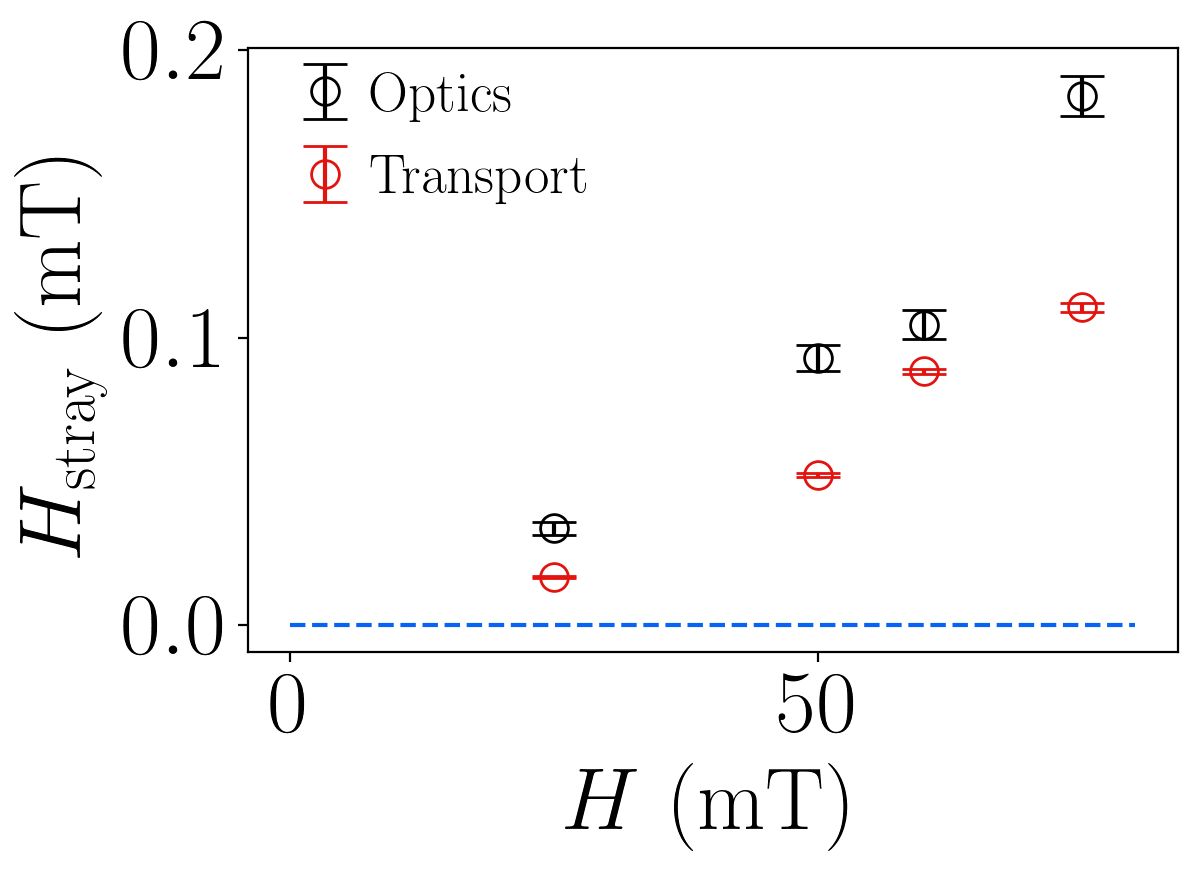

In [28]:
plt.figure(dpi=200)
plt.errorbar(qmoke_fit.field_strength*1e3,
             abs(qmoke_fit.a/Mpi*np.pi/2*qmoke_fit.field_strength)*1e3,
             abs(qmoke_fit.a_err/Mpi*np.pi/2*qmoke_fit.field_strength)*1e3,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',label='Optics')
plt.errorbar(phe_fit_tilt.field_strength*1e3,
             abs(phe_fit_tilt.b/(V/R*Rahe)*phe_fit_tilt.field_strength)*1e3,
             abs(phe_fit_tilt.b_err/(V/R*Rahe)*phe_fit_tilt.field_strength)*1e3,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',label='Transport')
plt.plot([0,80],[0,0],'C2',linestyle='--')
plt.xlabel('$H$ (mT)')
plt.ylabel('$H_{\\rm{stray}}$ (mT)')
plt.legend(loc='upper left',bbox_to_anchor=(0,1.05),frameon=False,
           columnspacing=0.5,handletextpad=0.3,handlelength=1,fontsize=20)

## Second Harmonic phi_H

In [ ]:
def secondHarm(x,x0,a,b,c):
    return -a*np.cos(np.pi/180*(x-x0)) + b*np.cos(np.pi/180*(x-x0))*np.cos(2*np.pi/180*(x-x0)) + c
def secondHarm_guess(*args,**kwargs):
    return [1,1,1,1]
secondHarmonic_fit = fit_dataArray(phe.TY2,secondHarm,secondHarm_guess,
                             ['phi0','a','b','c'],
                             'field_azimuth',bounds=((-180,-np.inf,-np.inf,-np.inf),(180,np.inf,np.inf,np.inf)),
                             xda=phe.field_azimuth)

In [ ]:
# plt.figure(dpi=200,figsize=(8,2))
plt.figure(dpi=200)
plt.errorbar(phe.field_azimuth+90,phe.sel(field_strength=0.025).TY2*1e6,label='0.025 T',
             fillstyle='none',fmt='o',ms=1)
plt.errorbar(phe.field_azimuth+90,phe.sel(field_strength=0.05).TY2*1e6+0.5,label='0.05 T',
             fillstyle='none',fmt='o',ms=1)
plt.errorbar(phe.field_azimuth+90,phe.sel(field_strength=0.075).TY2*1e6+1,label='0.075 T',
             fillstyle='none',fmt='o',ms=1)

plt.plot(phe.field_azimuth+90,secondHarm(phe.field_azimuth,
                               secondHarmonic_fit.phi0.sel(field_strength=0.025),
                               secondHarmonic_fit.a.sel(field_strength=0.025),
                               secondHarmonic_fit.b.sel(field_strength=0.025),
                               secondHarmonic_fit.c.sel(field_strength=0.025))*1e6,color='C0')

plt.plot(phe.field_azimuth+90,secondHarm(phe.field_azimuth,
                               secondHarmonic_fit.phi0.sel(field_strength=0.05),
                               secondHarmonic_fit.a.sel(field_strength=0.05),
                               secondHarmonic_fit.b.sel(field_strength=0.05),
                               secondHarmonic_fit.c.sel(field_strength=0.05))*1e6+0.5,color='C1')

plt.plot(phe.field_azimuth+90,secondHarm(phe.field_azimuth,
                               secondHarmonic_fit.phi0.sel(field_strength=0.075),
                               secondHarmonic_fit.a.sel(field_strength=0.075),
                               secondHarmonic_fit.b.sel(field_strength=0.075),
                               secondHarmonic_fit.c.sel(field_strength=0.075))*1e6+1,color='C2')
# plt.legend(loc='upper left',bbox_to_anchor=(-0.04,1),ncol=3,frameon=False,
#            columnspacing=0.5,handletextpad=0.3,handlelength=1,fontsize=16)
# plt.ylim(5.5,7.5)
plt.xlabel('$\\phi_H$ (deg)')
plt.xticks([-90,0,90,180,270])

plt.ylabel('$V^{2\\omega}_{XY}$ ($\\mu$V)',fontsize=24)

In [ ]:
plt.figure(dpi=200)
plt.errorbar(secondHarmonic_fit.field_strength,
             secondHarmonic_fit.a*1e6,
             secondHarmonic_fit.a_err*1e6,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label='$V^{2\\omega}_{\\rm{AHE}}$ Meas.')
plt.errorbar(secondHarmonic_fit.field_strength,
             secondHarmonic_fit.b*1e6,
             secondHarmonic_fit.b_err*1e6,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='$V^{2\\omega}_{\\rm{PHE}}$ Meas.')

ahe2phe = Rphe/Rahe

plt.errorbar(secondHarmonic_fit.field_strength,
             secondHarmonic_fit.a*ahe2phe*1e6*0.7,#0.7 is the ratio: Tfl/TDdl with the PHC
             secondHarmonic_fit.a_err*ahe2phe*1e6*0.7,#0.7 is the ratio: Tfl/Tdl with the PHC
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C2',
             label='$V^{2\\omega}_{\\rm{PHE}}$ Expec. PHC')

plt.errorbar(secondHarmonic_fit.field_strength,
             secondHarmonic_fit.a*ahe2phe*1e6*0.24,#0.24 is the ratio: Tfl/TDdl without the PHC
             secondHarmonic_fit.a_err*ahe2phe*1e6*0.24,#0.24 is the ratio: Tfl/Tdl without the PHC
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C3',
             label='$V^{2\\omega}_{\\rm{PHE}}$ Expec. no PHC')
plt.plot([0.02,0.08],[0,0],'k--')
plt.ylim(-0.05,0.3)
plt.legend(loc='upper left',bbox_to_anchor=(0,1),ncol=1,frameon=False,
           columnspacing=0.5,handletextpad=0.3,handlelength=1,fontsize=14)
plt.xlabel('$H$ (T)')
plt.ylabel('$V^{2\\omega}_{XY}$ ($\\mu$V)',fontsize=24)

## Tilting

In [14]:
def load_file(f):
    return pd.read_csv(f,comment='#').set_index('sweep_field').drop(columns='elapsed_time').to_xarray()
def load(v):
    ms = [-1,1]
    angs = [0,90]
    m_dict = {}
    for m in ms:
        ang_dict={}
        for ang in angs:
            if m == 1 and ang == 0:
                f = glob.glob('./*M+*%0.4f**A0.0*.csv'%v)[0]
                a = load_file(f)
            if m == -1 and ang == 0:
                f = glob.glob('./*M-*%0.4f**A0.0*.csv'%v)[0]
                a = load_file(f)
            if m == 1 and ang == 90:
                f = glob.glob('./*M+*%0.4f**A90.0*.csv'%v)[0]
                a = load_file(f)
            if m == -1 and ang == 90:
                f = glob.glob('./*M-*%0.4f**A90.0*.csv'%v)[0]
                a = load_file(f)
            ang_dict[ang] = a
        m_dict[m] = combine_new_dim(ang_dict,'field_azimuth')
    return combine_new_dim(m_dict,'M')

In [15]:
vs = np.arange(2,7.5,0.5)
a = combine_new_dim({v: load(v) for v in vs},'applied_voltage')
a['DeltaThetaK'] = a['DeltaThetaK']/2 #fixing the extra factor of two in the procedure code

In [16]:
def lin(x,m,b):
    return m*x+b
def lin_guess(*args,**kwargs):
    return [1,1]
def quad(x,a,b,c):
    return a*x**2 + b*x + c
def quad_guess(*args,**kwargs):
    return [1,1,1]

op_w1_fit = fit_dataArray(a.ThetaK,quad,quad_guess,['a','b','c'],'sweep_field')
op_w2_fit = fit_dataArray(a.DeltaThetaK,lin,lin_guess,['a','b'],'sweep_field')
xport_w1_fit = fit_dataArray(a.TX1,quad,quad_guess,['a','b','c'],'sweep_field')
xport_w2_fit = fit_dataArray(a.TY2,lin,lin_guess,['a','b'],'sweep_field')

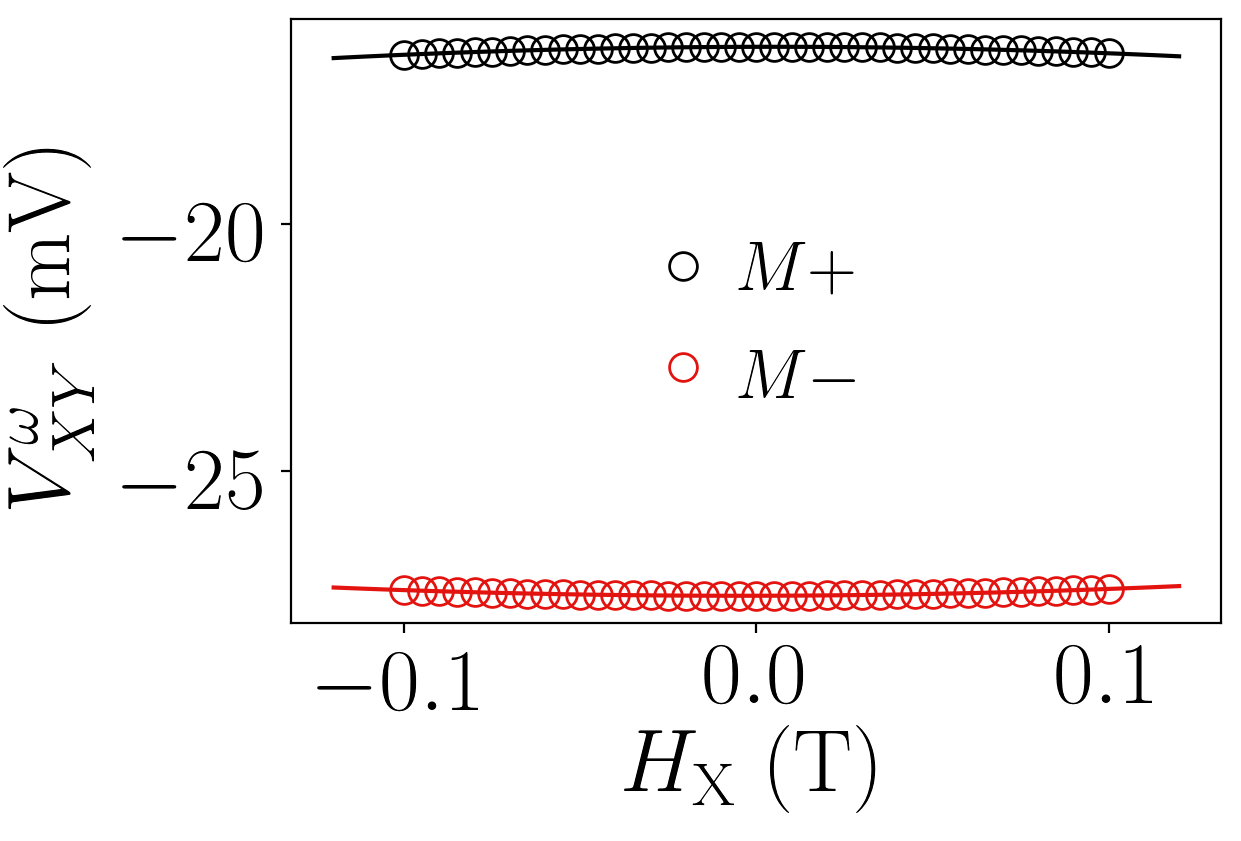

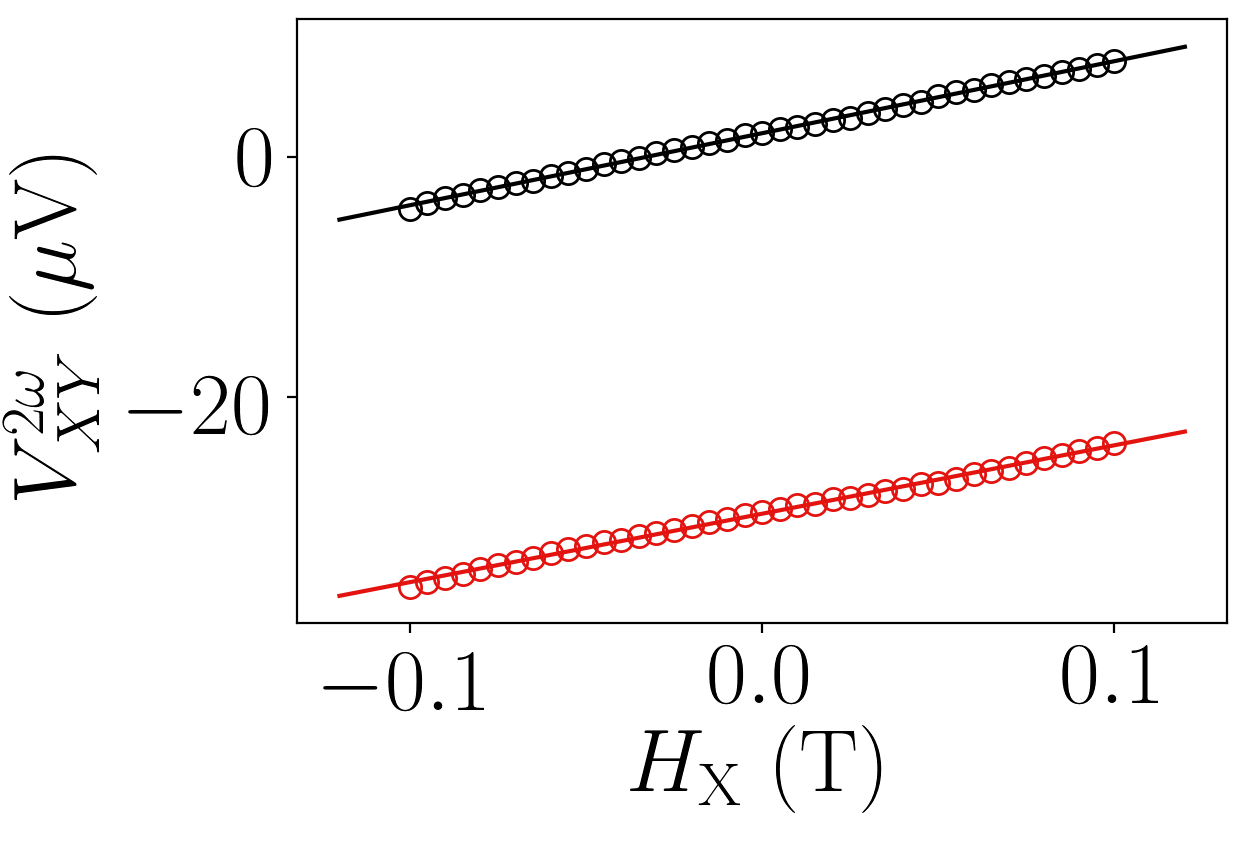

In [38]:
def plot_parab(tech,m,ang,v,newfig=False,fit=False,**kwargs):
    if tech == 'optics':
        comp = 'ThetaK'
        fit_ds = op_w1_fit.sel(M=m,field_azimuth=ang,applied_voltage=v)
        fac=-1
    if tech == 'xport':
        comp = 'TX1'
        fit_ds = xport_w1_fit.sel(M=m,field_azimuth=ang,applied_voltage=v)
        fac =1
    if m == 1:
        label = '$M+$'
        color = 'C0'
    else:
        label = '$M-$'
        color = 'C1'
    if newfig:
        plt.figure(dpi=200)
    plt.errorbar(a.sweep_field,fac*a.sel(M=m,field_azimuth=ang,applied_voltage=v)[comp]*1e3,
                 ms=10,fillstyle='none',label=label,color = color,**kwargs)
    if tech == 'optics':
        plt.ylabel('$\\theta_k$ (mRad)')
    if tech == 'xport':
        plt.ylabel('$V^{\omega}_{XY}$ (mV)')
    if ang == 90:
        plt.xlabel('$H_{\\rm{X}}$ (T)')
    if ang == 0:
        plt.xlabel('$H_{\\rm{Y}}$ (T)')
    
    if fit:
        xx = np.linspace(-0.12,0.12,100)
        plt.errorbar(xx,fac*1e3*quad(xx,
                         fit_ds.a.values,
                         fit_ds.b.values,
                         fit_ds.c.values),color = color)
    
def plot_lin(tech,m,ang,v,newfig=False,fit=False,off=0,**kwargs):
    if tech == 'optics':
        comp = 'DeltaThetaK'
        fac = -1
        fit_ds = op_w2_fit.sel(M=m,field_azimuth=ang,applied_voltage=v)
        if ang == 90:
            fac *= -1
    if tech == 'xport':
        comp = 'TY2'
        fac = 1
        fit_ds = xport_w2_fit.sel(M=m,field_azimuth=ang,applied_voltage=v)
    if m == 1:
        label = '$M+$'
        color = 'C0'
    else:
        label = '$M-$'
        color = 'C1'
    if newfig:
        plt.figure(dpi=200)
    plt.errorbar(a.sweep_field,fac*a.sel(M=m,field_azimuth=ang,applied_voltage=v)[comp]*1e6 + off,
                 ms=8,fillstyle='none',label=label,color = color,**kwargs)
    plt.ylabel('$\\Delta\\theta_k$ ($\\mu$Rad)')
    if ang == 90:
        plt.xlabel('$H_{\\rm{X}}$ (T)')
    if ang == 0:
        plt.xlabel('$H_{\\rm{Y}}$ (T)')
    if tech == 'optics':
        plt.ylabel('$\\Delta\\theta_k$ ($\\mu$Rad)')
    if tech == 'xport':
        plt.ylabel('$V^{2\omega}_{XY}$ ($\\mu$V)')
    if fit:
        xx = np.linspace(-0.12,0.12,100)
        plt.errorbar(xx,fac*1e6*lin(xx,
                         fit_ds.a.values,
                         fit_ds.b.values)+off,color = color)
    

plot_parab('xport',1,90,5,newfig=True,fit=True,fmt='o')
plot_parab('xport',-1,90,5,fit=True,fmt='o')    
plt.legend(loc='center',bbox_to_anchor=(0.5,0.5),
           frameon=False, columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=25)
plot_lin('xport',1,90,5,newfig=True,fit=True,off=10,fmt='o')
plot_lin('xport',-1,90,5,fit=True,off=-10,fmt='o')
# plt.legend(loc='center',bbox_to_anchor=(0.5,0.5),
#            frameon=False, columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=25)

# plot_parab(1,90,newfig=True,color='C0',fmt='o')
# plot_parab(-1,90,color='C1',fmt='o')


In [30]:
theta2m = Mpi/2 #rad kerr / rad mag
optics_Meff = float(np.sqrt(1/abs(op_w1_fit.a*2/theta2m))\
                    .where(op_w1_fit.applied_voltage<5).mean())
xport_Meff = float(1/np.sqrt(abs(xport_w1_fit.a*2/Rahe/(xport_w1_fit.applied_voltage/R)))\
                   .where(xport_w1_fit.applied_voltage<5).mean())


print(optics_Meff,xport_Meff)

0.4176708163337826 0.42354831882491806


In [31]:
op_SOT = op_w2_fit.a/op_w1_fit.a/2
op_SOT.name = 'H'
op_SOT_err = op_w2_fit.a/op_w1_fit.a/2*np.sqrt((op_w2_fit.a_err/op_w2_fit.a)**2 +\
                                               (op_w1_fit.a_err/op_w1_fit.a)**2)
op_SOT_err.name = 'H_err'
op_SOT = xr.merge([op_SOT,op_SOT_err])
op_SOT = op_SOT.assign(H_norm = lambda x: x.H*A*1e4/(x.applied_voltage/R * Isplit))
op_SOT = op_SOT.assign(H_norm_err = lambda x: x.H_err*A*1e4/(x.applied_voltage/R * Isplit))

op_SOT

<xarray.Dataset>
Dimensions:          (M: 2, applied_voltage: 11, field_azimuth: 2)
Coordinates:
  * field_azimuth    (field_azimuth) int64 0 90
  * M                (M) int64 -1 1
  * applied_voltage  (applied_voltage) float64 2.0 2.5 3.0 3.5 ... 6.0 6.5 7.0
Data variables:
    H                (applied_voltage, M, field_azimuth) float64 -0.0003392 ....
    H_err            (applied_voltage, M, field_azimuth) float64 -0.0001596 ....
    H_norm           (applied_voltage, M, field_azimuth) float64 -1.003e-06 ....
    H_norm_err       (applied_voltage, M, field_azimuth) float64 -4.72e-07 .....

In [32]:
xi = Rphe/Rahe
xport_SOT = -xport_w2_fit.a/xport_w1_fit.a # no factor of 2 therefore no multiply by 2 at the end
xport_SOT.name = 'H'
xport_SOT_err = xport_w2_fit.a/xport_w1_fit.a*np.sqrt((xport_w2_fit.a_err/xport_w2_fit.a)**2 +\
                                                      (xport_w1_fit.a_err/xport_w1_fit.a)**2)
xport_SOT_err.name = 'H_err'
xport_SOT = xr.merge([xport_SOT,xport_SOT_err])
xport_SOT = xport_SOT.assign(H_norm = lambda x: x.H*A*1e4/(x.applied_voltage/R * Isplit))
xport_SOT = xport_SOT.assign(H_norm_err = lambda x: x.H_err*A*1e4/(x.applied_voltage/R * Isplit))

xport_SOT_PHC = xport_w2_fit.a/xport_w1_fit.a/2
xport_SOT_PHC.name = 'H'
xport_SOT_PHC_err = xport_w2_fit.a/xport_w1_fit.a/2*np.sqrt((xport_w2_fit.a_err/xport_w2_fit.a)**2 +\
                                                      (xport_w1_fit.a_err/xport_w1_fit.a)**2)
xport_SOT_PHC_err.name = 'H_err'
xport_SOT_PHC = xr.merge([xport_SOT_PHC,xport_SOT_PHC_err])
xport_SOT_PHC = combine_new_dim({
    90: -2*(xport_SOT_PHC.H.sel(field_azimuth=90) + xi*xport_SOT_PHC.M*xport_SOT_PHC.H.sel(field_azimuth=0))\
           /(1-xi**2),
    0: -2*(xport_SOT_PHC.H.sel(field_azimuth=0) + xi*xport_SOT_PHC.M*xport_SOT_PHC.H.sel(field_azimuth=90))\
           /(1-xi**2)}, 'field_azimuth')
xport_SOT_PHC.name = 'H'
xport_SOT_PHC_err = 2*xport_SOT_PHC_err/(1-xi**2)
xport_SOT_PHC_err.name = 'H_err'
xport_SOT_PHC = xr.merge([xport_SOT_PHC,xport_SOT_PHC_err])

xport_SOT_PHC = xport_SOT_PHC.assign(H_norm = lambda x: x.H*A*1e4/(x.applied_voltage/R * Isplit))
xport_SOT_PHC = xport_SOT_PHC.assign(H_norm_err = lambda x: x.H_err*A*1e4/(x.applied_voltage/R * Isplit))

xport_SOT = combine_new_dim({'noPHC':xport_SOT,'PHC':xport_SOT_PHC},'PHC')

xport_SOT

<xarray.Dataset>
Dimensions:          (M: 2, PHC: 2, applied_voltage: 11, field_azimuth: 2)
Coordinates:
  * field_azimuth    (field_azimuth) int64 0 90
  * M                (M) int64 -1 1
  * applied_voltage  (applied_voltage) float64 2.0 2.5 3.0 3.5 ... 6.0 6.5 7.0
  * PHC              (PHC) <U5 'noPHC' 'PHC'
Data variables:
    H                (PHC, applied_voltage, M, field_azimuth) float64 0.00049...
    H_err            (PHC, applied_voltage, M, field_azimuth) float64 -2.02e-...
    H_norm           (PHC, applied_voltage, M, field_azimuth) float64 1.463e-...
    H_norm_err       (PHC, applied_voltage, M, field_azimuth) float64 -5.973e...

In [33]:
def slope(x,m):
    return m*x
def slope_guess(*args,**kwargs):
    return [1]
op_SOT_lin_fit = fit_dataArray(op_SOT.H*1e4,slope,slope_guess,['m'],'applied_voltage',
                               yerr_da=op_SOT.H_err*1e4,
                               xda = op_SOT.applied_voltage/R/A * Isplit)
xport_SOT_lin_fit = fit_dataArray(xport_SOT.H*1e4,slope,slope_guess,['m'],'applied_voltage',
                               yerr_da=xport_SOT.H_err*1e4,
                               xda = xport_SOT.applied_voltage/R/A * Isplit, 
                               applied_voltage = [x for x in xport_SOT.applied_voltage if x < 5])

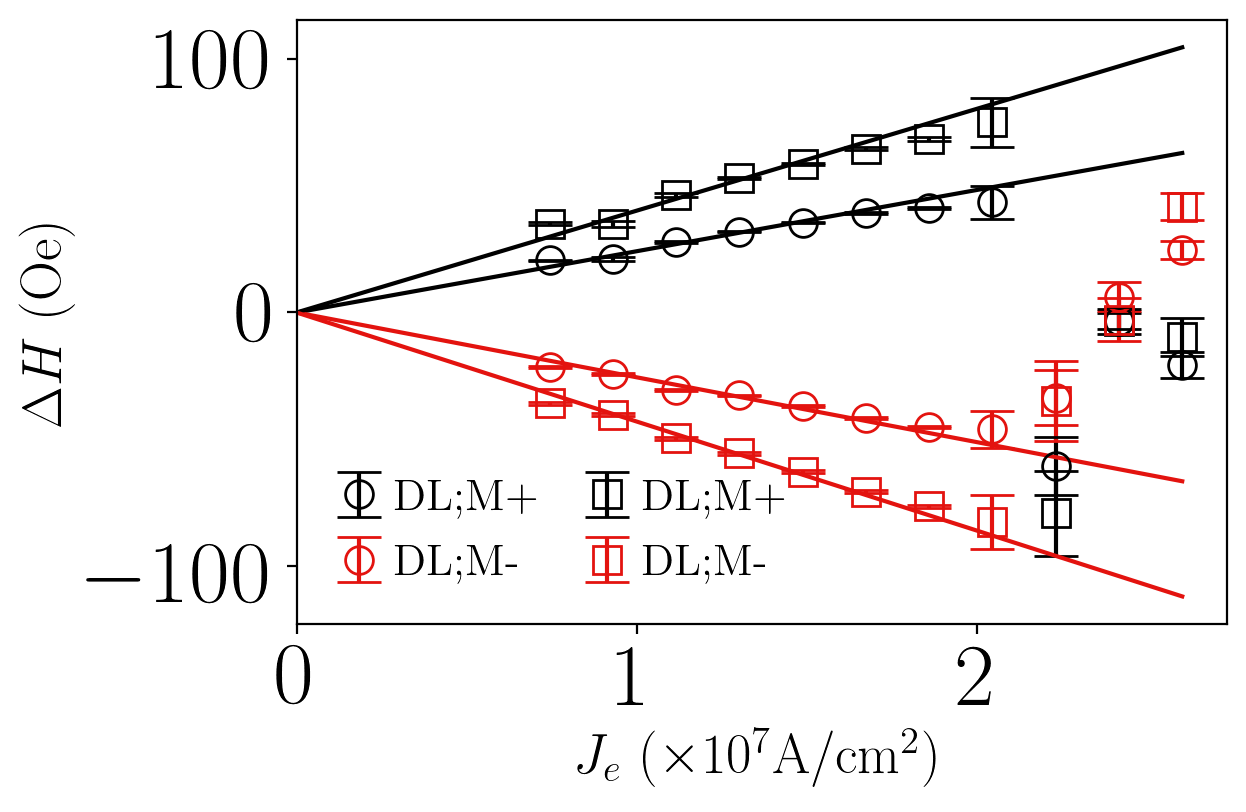

In [34]:
plt.figure(dpi=200)
plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
             xport_SOT.sel(field_azimuth=90,M=1,PHC='noPHC').H*1e4,
             xport_SOT.sel(field_azimuth=90,M=1,PHC='noPHC').H_err*1e4,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label='DL;M+')
plt.plot(np.linspace(0,7,2)/R/A*1e-7,
         xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='noPHC').m.values*np.linspace(0,7,2)/R/A * Isplit,'C0')

plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
             xport_SOT.sel(field_azimuth=90,M=-1,PHC='noPHC').H*1e4,
             xport_SOT.sel(field_azimuth=90,M=-1,PHC='noPHC').H_err*1e4,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='DL;M-')
plt.plot(np.linspace(0,7,2)/R/A*1e-7,
         xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='noPHC').m.values*np.linspace(0,7,2)/R/A * Isplit,'C1')

plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
             xport_SOT.sel(field_azimuth=90,M=1,PHC='PHC').H*1e4,
             xport_SOT.sel(field_azimuth=90,M=1,PHC='PHC').H_err*1e4,
             fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label='DL;M+')
plt.plot(np.linspace(0,7,2)/R/A*1e-7,
         xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='PHC').m.values*np.linspace(0,7,2)/R/A * Isplit,'C0')

plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
             xport_SOT.sel(field_azimuth=90,M=-1,PHC='PHC').H*1e4,
             xport_SOT.sel(field_azimuth=90,M=-1,PHC='PHC').H_err*1e4,
             fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='DL;M-')
plt.plot(np.linspace(0,7,2)/R/A*1e-7,
         xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='PHC').m.values*np.linspace(0,7,2)/R/A * Isplit,'C1')

# plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
#              xport_SOT.sel(field_azimuth=0,M=1,PHC='noPHC').H*1e4,
#              xport_SOT.sel(field_azimuth=0,M=1,PHC='noPHC').H_err*1e4,
#              fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
#              label='FL;M+')
# plt.plot(np.linspace(0,7,2)/R/A*1e-7,
#          xport_SOT_lin_fit.sel(field_azimuth=0,M=1,PHC='noPHC').m.values*np.linspace(0,7,2)/R/A * Isplit,'C0')

# plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
#              xport_SOT.sel(field_azimuth=0,M=-1,PHC='noPHC').H*1e4,
#              xport_SOT.sel(field_azimuth=0,M=-1,PHC='noPHC').H_err*1e4,
#              fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
#              label='FL;M-')
# plt.plot(np.linspace(0,7,2)/R/A*1e-7,
#          xport_SOT_lin_fit.sel(field_azimuth=0,M=-1,PHC='noPHC').m.values*np.linspace(0,7,2)/R/A * Isplit,'C1')
plt.xlim(0,)
# plt.ylim(0,)
plt.ylabel('$\\Delta H$ (Oe)',fontsize=20)
plt.xlabel('$J_e$ ($\\times 10^{7}$A/cm$^2$)',fontsize=20)

plt.legend(loc='lower left',bbox_to_anchor=(0,0),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=16)

In [75]:
(xport_SOT.H.sel(PHC='PHC',applied_voltage=3,field_azimuth=90))

<xarray.DataArray 'H' (M: 2)>
array([-0.0049688 ,  0.00464425])
Coordinates:
    field_azimuth    int64 90
  * M                (M) int64 -1 1
    applied_voltage  float64 3.0
    PHC              <U5 'PHC'

In [73]:
(xport_SOT.H_err.sel(PHC='noPHC',applied_voltage=3,field_azimuth=0))

<xarray.DataArray 'H_err' (M: 2)>
array([-1.25920725e-05, -1.46027911e-05])
Coordinates:
    field_azimuth    int64 0
  * M                (M) int64 -1 1
    applied_voltage  float64 3.0
    PHC              <U5 'noPHC'

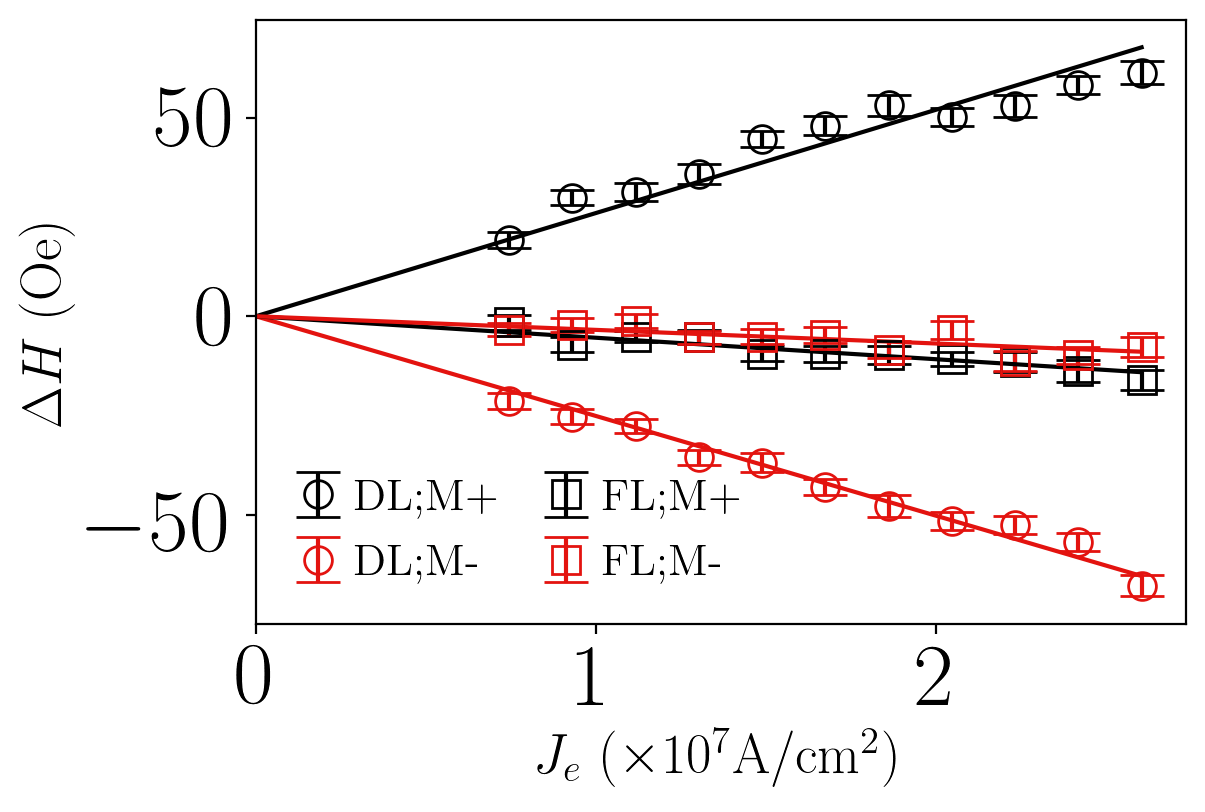

In [35]:
plt.figure(dpi=200)
plt.errorbar(op_SOT.applied_voltage/R/A*1e-7,
             op_SOT.sel(field_azimuth=90,M=1).H*1e4,
             op_SOT.sel(field_azimuth=90,M=1).H_err*1e4,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label='DL;M+')
plt.plot(np.linspace(0,7,2)/R/A*1e-7,
         op_SOT_lin_fit.sel(field_azimuth=90,M=1).m.values*np.linspace(0,7,2)/R/A * Isplit,'C0')

plt.errorbar(op_SOT.applied_voltage/R/A*1e-7,
             op_SOT.sel(field_azimuth=90,M=-1).H*1e4,
             op_SOT.sel(field_azimuth=90,M=-1).H_err*1e4,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='DL;M-')
plt.plot(np.linspace(0,7,2)/R/A*1e-7,
         op_SOT_lin_fit.sel(field_azimuth=90,M=-1).m.values*np.linspace(0,7,2)/R/A * Isplit,'C1')

plt.errorbar(op_SOT.applied_voltage/R/A*1e-7,
             op_SOT.sel(field_azimuth=0,M=1).H*1e4,
             op_SOT.sel(field_azimuth=0,M=1).H_err*1e4,
             fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label='FL;M+')
plt.plot(np.linspace(0,7,2)/R/A*1e-7,
         op_SOT_lin_fit.sel(field_azimuth=0,M=1).m.values*np.linspace(0,7,2)/R/A * Isplit,'C0')

plt.errorbar(op_SOT.applied_voltage/R/A*1e-7,
             op_SOT.sel(field_azimuth=0,M=-1).H*1e4,
             op_SOT.sel(field_azimuth=0,M=-1).H_err*1e4,
             fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
             label='FL;M-')
plt.plot(np.linspace(0,7,2)/R/A*1e-7,
         op_SOT_lin_fit.sel(field_azimuth=0,M=-1).m.values*np.linspace(0,7,2)/R/A * Isplit,'C1')
plt.xlim(0,)
# plt.ylim(0,)
plt.ylabel('$\\Delta H$ (Oe)',fontsize=20)
plt.xlabel('$J_e$ ($\\times 10^{7}$A/cm$^2$)',fontsize=20)

plt.legend(loc='lower left',bbox_to_anchor=(0,0),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=16)

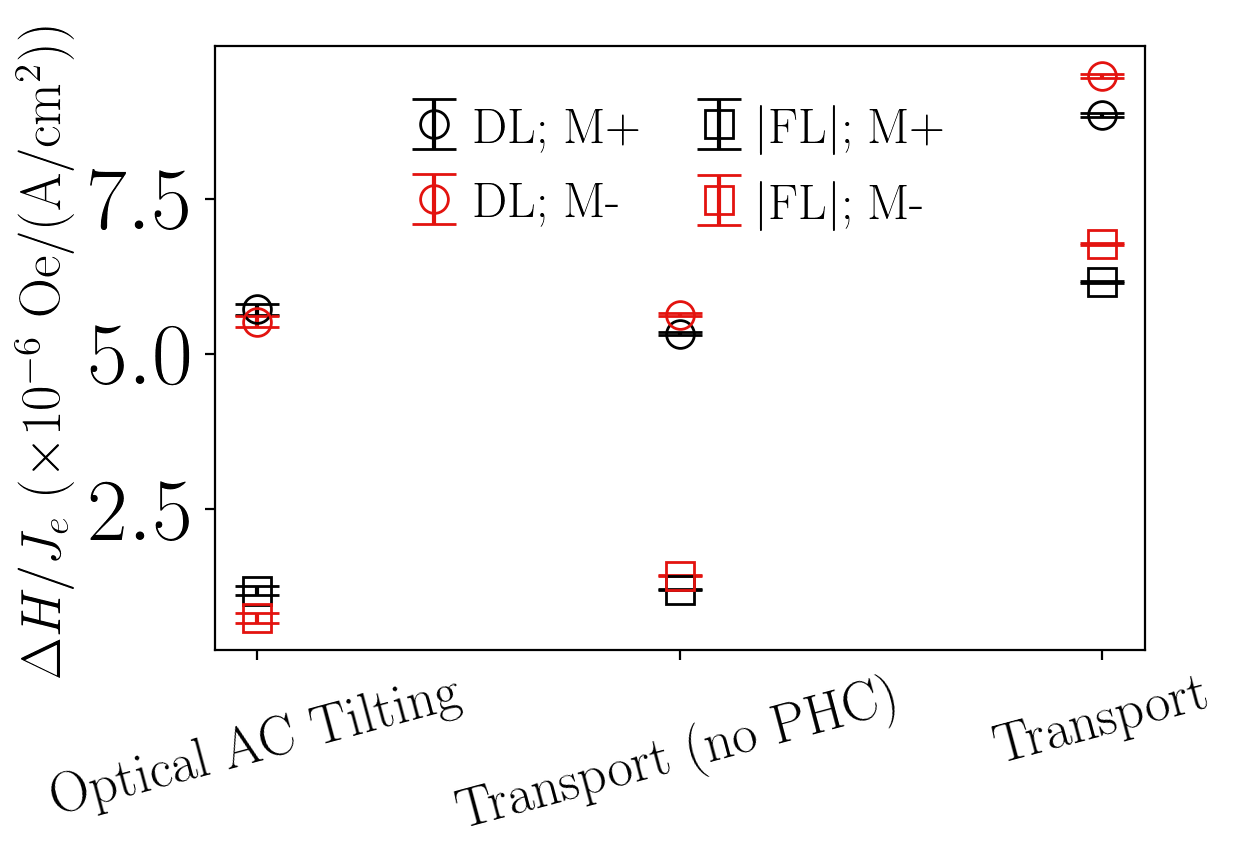

In [65]:
plt.figure(dpi=200)
plt.errorbar([0],op_SOT_lin_fit.sel(field_azimuth=90,M=1).m*1e6,
                 op_SOT_lin_fit.sel(field_azimuth=90,M=1).m_err*1e6,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
                 label='DL; M+')
plt.errorbar([0],-op_SOT_lin_fit.sel(field_azimuth=90,M=-1).m*1e6,
                 op_SOT_lin_fit.sel(field_azimuth=90,M=-1).m_err*1e6,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
                 label='DL; M-')

plt.errorbar([1],xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='noPHC').m*1e6,
                 xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='noPHC').m_err*1e6,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.errorbar([1],-xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='noPHC').m*1e6,
                 xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='noPHC').m_err*1e6,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')

plt.errorbar([2],xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='PHC').m*1e6,
                 xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='PHC').m_err*1e6,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.errorbar([2],-xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='PHC').m*1e6,
                 xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='PHC').m_err*1e6,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')

# ----- FL ---------#
#plt.figure(dpi=200)
plt.errorbar([0],abs(op_SOT_lin_fit.sel(field_azimuth=0,M=1).m*1e6),
                 op_SOT_lin_fit.sel(field_azimuth=0,M=1).m_err*1e6,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
                 label='$|$FL$|$; M+')
plt.errorbar([0],abs(op_SOT_lin_fit.sel(field_azimuth=0,M=-1).m*1e6),
                 op_SOT_lin_fit.sel(field_azimuth=0,M=-1).m_err*1e6,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
                 label='$|$FL$|$; M-')

plt.errorbar([1],abs(xport_SOT_lin_fit.sel(field_azimuth=0,M=1,PHC='noPHC').m*1e6),
                 xport_SOT_lin_fit.sel(field_azimuth=0,M=1,PHC='noPHC').m_err*1e6,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.errorbar([1],abs(xport_SOT_lin_fit.sel(field_azimuth=0,M=-1,PHC='noPHC').m*1e6),
                 xport_SOT_lin_fit.sel(field_azimuth=0,M=-1,PHC='noPHC').m_err*1e6,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')

plt.errorbar([2],abs(xport_SOT_lin_fit.sel(field_azimuth=0,M=1,PHC='PHC').m*1e6),
                 xport_SOT_lin_fit.sel(field_azimuth=0,M=1,PHC='PHC').m_err*1e6,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.errorbar([2],abs(xport_SOT_lin_fit.sel(field_azimuth=0,M=-1,PHC='PHC').m*1e6),
                 xport_SOT_lin_fit.sel(field_azimuth=0,M=-1,PHC='PHC').m_err*1e6,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')


plt.xticks([0,1,2],
           ['Optical AC Tilting','Transport (no PHC)','Transport'],
           rotation = 15,fontsize=20)
plt.ylabel('$\\Delta H/J_e$ ($\\times 10^{-6}$ Oe/(A/cm$^2))$',fontsize=20)
plt.legend(loc='center',bbox_to_anchor=(0.5,0.8),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=18)

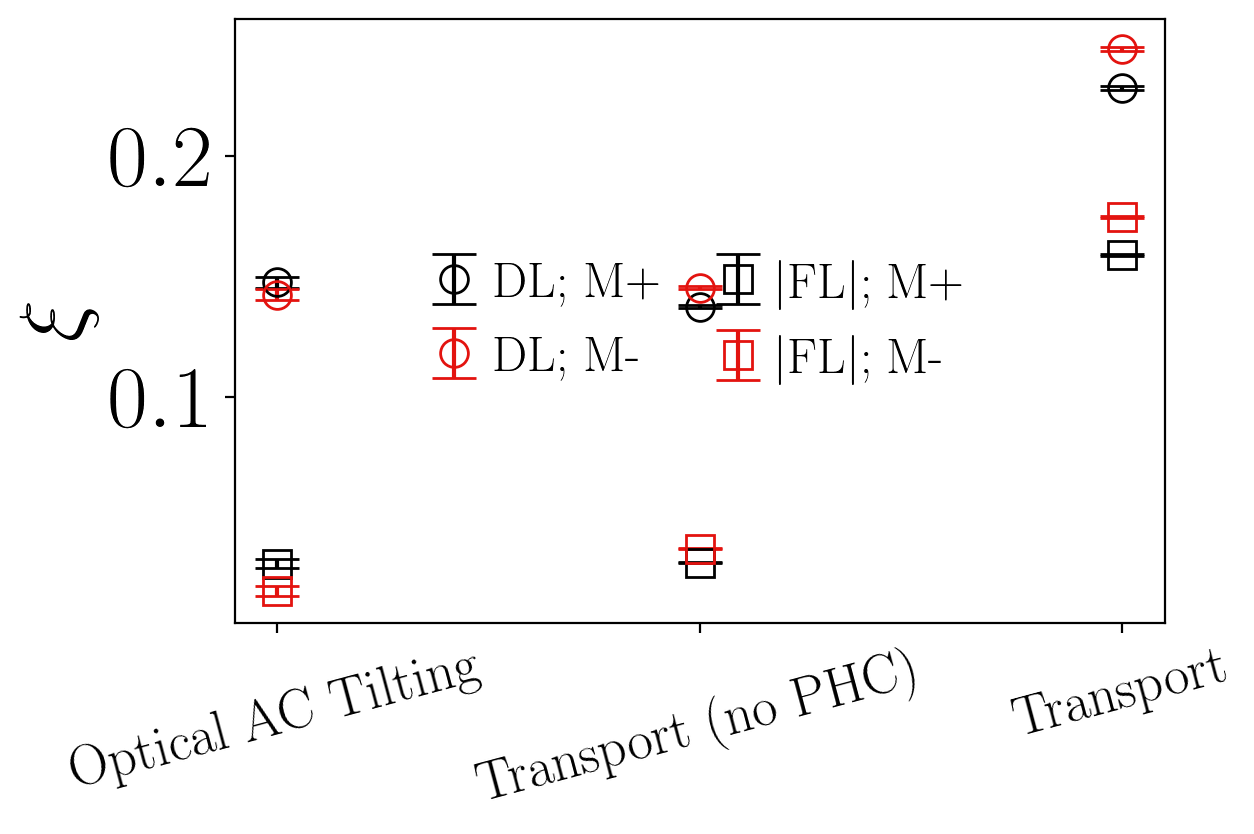

In [66]:
plt.figure(dpi=200)
plt.errorbar([0],op_SOT_lin_fit.sel(field_azimuth=90,M=1).m*t2xi/1e4,
                 op_SOT_lin_fit.sel(field_azimuth=90,M=1).m_err*t2xi/1e4,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
                 label='DL; M+')
plt.errorbar([0],-op_SOT_lin_fit.sel(field_azimuth=90,M=-1).m*t2xi/1e4,
                 op_SOT_lin_fit.sel(field_azimuth=90,M=-1).m_err*t2xi/1e4,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
                 label='DL; M-')

plt.errorbar([1],xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='noPHC').m*t2xi/1e4,
                 xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='noPHC').m_err*t2xi/1e4,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.errorbar([1],-xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='noPHC').m*t2xi/1e4,
                 xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='noPHC').m_err*t2xi/1e4,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')

plt.errorbar([2],xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='PHC').m*t2xi/1e4,
                 xport_SOT_lin_fit.sel(field_azimuth=90,M=1,PHC='PHC').m_err*t2xi/1e4,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.errorbar([2],-xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='PHC').m*t2xi/1e4,
                 xport_SOT_lin_fit.sel(field_azimuth=90,M=-1,PHC='PHC').m_err*t2xi/1e4,
                 fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')

# ----- FL ---------#
#plt.figure(dpi=200)
plt.errorbar([0],abs(op_SOT_lin_fit.sel(field_azimuth=0,M=1).m*t2xi/1e4),
                 op_SOT_lin_fit.sel(field_azimuth=0,M=1).m_err*t2xi/1e4,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
                 label='$|$FL$|$; M+')
plt.errorbar([0],abs(op_SOT_lin_fit.sel(field_azimuth=0,M=-1).m*t2xi/1e4),
                 op_SOT_lin_fit.sel(field_azimuth=0,M=-1).m_err*t2xi/1e4,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
                 label='$|$FL$|$; M-')

plt.errorbar([1],abs(xport_SOT_lin_fit.sel(field_azimuth=0,M=1,PHC='noPHC').m*t2xi/1e4),
                 xport_SOT_lin_fit.sel(field_azimuth=0,M=1,PHC='noPHC').m_err*t2xi/1e4,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.errorbar([1],abs(xport_SOT_lin_fit.sel(field_azimuth=0,M=-1,PHC='noPHC').m*t2xi/1e4),
                 xport_SOT_lin_fit.sel(field_azimuth=0,M=-1,PHC='noPHC').m_err*t2xi/1e4,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')

plt.errorbar([2],abs(xport_SOT_lin_fit.sel(field_azimuth=0,M=1,PHC='PHC').m*t2xi/1e4),
                 xport_SOT_lin_fit.sel(field_azimuth=0,M=1,PHC='PHC').m_err*t2xi/1e4,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0')
plt.errorbar([2],abs(xport_SOT_lin_fit.sel(field_azimuth=0,M=-1,PHC='PHC').m*t2xi/1e4),
                 xport_SOT_lin_fit.sel(field_azimuth=0,M=-1,PHC='PHC').m_err*t2xi/1e4,
                 fmt='s',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1')


plt.xticks([0,1,2],
           ['Optical AC Tilting','Transport (no PHC)','Transport'],
           rotation = 15,fontsize=20)
plt.ylabel('$\\xi$')
plt.legend(loc='center',bbox_to_anchor=(0.5,0.5),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=18)

In [83]:
np.abs(xport_SOT_lin_fit.m).mean('M').sel(PHC='noPHC').sel(field_azimuth=0)/\
np.abs(xport_SOT_lin_fit.m).mean('M').sel(PHC='noPHC').sel(field_azimuth=90)

<xarray.DataArray 'm' ()>
array(0.24037257)
Coordinates:
    PHC      <U5 'noPHC'

In [67]:
(op_SOT_lin_fit.fit_ds*t2xi/1e4).to_netcdf('./../all_devs/Meff%0.3f_op.nc'%np.mean([optics_Meff,xport_Meff]))
(xport_SOT_lin_fit.fit_ds*t2xi/1e4).to_netcdf('./../all_devs/Meff%0.3f_xport.nc'%np.mean([optics_Meff,xport_Meff]))
np.save('./../all_devs/Meff%0.3f_xi'%np.mean([optics_Meff,xport_Meff]), [xi])

## NIST Method

In [1]:
Cahe = -(xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).applied_voltage/R)*Rahe/2/xport_Meff**2
Cphe = -(xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).applied_voltage/R)*Rphe/2/xport_Meff**2
Spx = xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).sel(M=1,field_azimuth=90).a
Spx_err = xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).sel(M=1,field_azimuth=90).a_err
Spy = xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).sel(M=1,field_azimuth=0).a
Spy_err = xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).sel(M=1,field_azimuth=0).a_err
Smx = xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).sel(M=-1,field_azimuth=90).a
Smx_err = xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).sel(M=-1,field_azimuth=90).a_err
Smy = xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).sel(M=-1,field_azimuth=0).a
Smy_err = xport_w2_fit.where(xport_w2_fit.applied_voltage<5,drop=True).sel(M=-1,field_azimuth=0).a_err

xport_SOT = xport_SOT.where(xport_SOT.applied_voltage < 5,drop=True)

C = 1/(2*Cahe**2 - 2*Cphe**2)

hx = 1e4*C*(-Cahe*Spx - Cahe*Smx - Cphe*Spy + Cphe*Smy)
hx_err = 1e4*C*(np.sqrt((Cahe*Spx_err)**2 + (Cahe*Smx_err)**2 + (Cphe*Spy_err)**2 + (Cphe*Smy_err)**2))
hy = 1e4*C*(-Cphe*Spx - Cphe*Smx - Cahe*Spy + Cahe*Smy)
hy_err = 1e4*C*(np.sqrt((Cphe*Spx_err)**2 + (Cphe*Smx_err)**2 + (Cahe*Spy_err)**2 + (Cahe*Smy_err)**2))

hxpar = (Smx - Spx)/2/Cahe*1e4
hxpar_err = np.sqrt(Smx_err**2 + Spx_err**2)/2/Cahe*1e4
hypar = (Smx + Spx)/2/Cphe*1e4
hypar_err = np.sqrt(Smx_err**2 + Spx_err**2)/2/Cphe*1e4
hxperp = -(Smy + Spy)/2/Cphe*1e4
hxperp_err = np.sqrt(Smy_err**2 + Spy_err**2)/2/Cphe*1e4
hyperp = (Smy - Spy)/2/Cahe*1e4
hyperp_err = np.sqrt(Smy_err**2 + Spy_err**2)/2/Cahe*1e4

#====================================


plt.figure(dpi=200)
plt.errorbar(hx.applied_voltage/R/A*1e-7,hx,hx_err,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label='NIST $\\Delta H$')

fit = fit_dataArray(hx,slope,slope_guess,['m'], xname='applied_voltage',
                    xda=hx.applied_voltage/R/A*1e-7,
                    yerr_da = hx_err, 
                    applied_voltage = [x for x in hx.applied_voltage if x < 5])
plt.plot([0,2.2],fit.m.values*np.array([0,2.2]),'C0')

# plt.errorbar(hx.applied_voltage/R/A*1e-7,hxpar,hxpar_err,
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
#              label='NIST $\\Delta H^{\\parallel}$')

# fit = fit_dataArray(hxpar,slope,slope_guess,['m'], xname='applied_voltage',
#                     xda=hx.applied_voltage/R/A*1e-7,
#                     yerr_da = hxpar_err, 
#                     applied_voltage = [x for x in hx.applied_voltage if x < 5])
# plt.plot([0,2.2],fit.m.values*np.array([0,2.2]),'C1')

# plt.errorbar(hx.applied_voltage/R/A*1e-7,abs(hxperp),hxperp_err,
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C4',
#              label='NIST $\\Delta H^{\\perp}$')

plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
             abs(xport_SOT.sel(field_azimuth=90,PHC='PHC')).mean('M').H*1e4,
             abs(xport_SOT.sel(field_azimuth=90,PHC='PHC')).mean('M').H_err*1e4,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C2',
             label='Hayashi; PHC')
fit = fit_dataArray(abs(xport_SOT.sel(field_azimuth=90,PHC='PHC')).mean('M').H*1e4,
                    slope,slope_guess,['m'], xname='applied_voltage',
                    xda=hx.applied_voltage/R/A*1e-7,
                    yerr_da = abs(xport_SOT.sel(field_azimuth=90,PHC='PHC')).mean('M').H_err*1e4, 
                    applied_voltage = [x for x in hx.applied_voltage if x < 5])
plt.plot([0,2.2],fit.m.values*np.array([0,2.2]),'C2')

plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
             abs(xport_SOT.sel(field_azimuth=90,PHC='noPHC')).mean('M').H*1e4,
             abs(xport_SOT.sel(field_azimuth=90,PHC='noPHC')).mean('M').H_err*1e4,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C3',
             label='Hayashi; no PHC')
fit = fit_dataArray(abs(xport_SOT.sel(field_azimuth=90,PHC='noPHC')).mean('M').H*1e4,
                    slope,slope_guess,['m'], xname='applied_voltage',
                    xda=hx.applied_voltage/R/A*1e-7,
                    yerr_da = abs(xport_SOT.sel(field_azimuth=90,PHC='noPHC')).mean('M').H_err*1e4, 
                    applied_voltage = [x for x in hx.applied_voltage if x < 5])
plt.plot([0,2.2],fit.m.values*np.array([0,2.2]),'C3')

plt.xlabel('$J_e$ ($\\times 10^7$ A/cm$^2$)')
plt.ylabel('$\\Delta H_X$ (Oe)')
plt.legend(loc='upper left',bbox_to_anchor=(-0.01,1),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=14)

#====================================

plt.figure(dpi=200)
plt.errorbar(hy.applied_voltage/R/A*1e-7,-hy,hy_err,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C0',
             label='NIST $\\Delta H$')

fit = fit_dataArray(-hy,slope,slope_guess,['m'], xname='applied_voltage',
                    xda=hy.applied_voltage/R/A*1e-7,
                    yerr_da = hy_err, 
                    applied_voltage = [x for x in hx.applied_voltage if x < 5])
plt.plot([0,2.2],fit.m.values*np.array([0,2.2]),'C0')

# plt.errorbar(hy.applied_voltage/R/A*1e-7,-hyperp,hyperp_err,
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C1',
#              label='NIST $\\Delta H^{\\perp}$')

# fit = fit_dataArray(-hyperp,slope,slope_guess,['m'], xname='applied_voltage',
#                     xda=hy.applied_voltage/R/A*1e-7,
#                     yerr_da = hyperp_err, 
#                     applied_voltage = [x for x in hx.applied_voltage if x < 5])
# plt.plot([0,2.2],fit.m.values*np.array([0,2.2]),'C1')

# plt.errorbar(hy.applied_voltage/R/A*1e-7,hypar,hypar_err,
#              fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C4',
#              label='NIST $\\Delta H^{\\parallel}$')

plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
             abs(xport_SOT.sel(field_azimuth=0,PHC='PHC')).mean('M').H*1e4,
             abs(xport_SOT.sel(field_azimuth=0,PHC='PHC')).mean('M').H_err*1e4,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C2',
             label='Hayashi; PHC')
fit = fit_dataArray(abs(xport_SOT.sel(field_azimuth=0,PHC='PHC')).mean('M').H*1e4,
                    slope,slope_guess,['m'], xname='applied_voltage',
                    xda=hx.applied_voltage/R/A*1e-7,
                    yerr_da = abs(xport_SOT.sel(field_azimuth=0,PHC='PHC')).mean('M').H_err*1e4, 
                    applied_voltage = [x for x in hx.applied_voltage if x < 5])
plt.plot([0,2.2],fit.m.values*np.array([0,2.2]),'C2')

plt.errorbar(xport_SOT.applied_voltage/R/A*1e-7,
             abs(xport_SOT.sel(field_azimuth=0,PHC='noPHC')).mean('M').H*1e4,
             abs(xport_SOT.sel(field_azimuth=0,PHC='noPHC')).mean('M').H_err*1e4,
             fmt='o',linestyle='none',ms=10,capsize=8,fillstyle='none',color = 'C3',
             label='Hayashi; no PHC')
fit = fit_dataArray(abs(xport_SOT.sel(field_azimuth=0,PHC='noPHC')).mean('M').H*1e4,
                    slope,slope_guess,['m'], xname='applied_voltage',
                    xda=hx.applied_voltage/R/A*1e-7,
                    yerr_da = abs(xport_SOT.sel(field_azimuth=0,PHC='noPHC')).mean('M').H_err*1e4, 
                    applied_voltage = [x for x in hx.applied_voltage if x < 5])
plt.plot([0,2.2],fit.m.values*np.array([0,2.2]),'C3')


plt.xlabel('$J_e$ ($\\times 10^7$ A/cm$^2$)')
plt.ylabel('$|\\Delta H_Y|$ (Oe)')
plt.legend(loc='upper left',bbox_to_anchor=(-0.01,1),ncol=2,frameon=False,
           columnspacing=1,handletextpad=0.3,handlelength=1,fontsize=14)

NameError: name 'xport_w2_fit' is not defined